In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pymc as pm
import os
import sys
from torch.utils.data import DataLoader

sys.path.append(os.path.abspath('../src'))
from data_tools.data_utils import ReportingDataset, create_data_split

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
project_dir = project_dir = Path.cwd().parent
device = 'mps'

In [2]:

trunc_D = 40


create_data_split(
    start_year=2013,
    end_year=2020,
    D=trunc_D,
    data_folder_path = project_dir / "data",
    input_filename="DENGSP.csv",
    train_prop=0.7,
    val_prop=0.2,
    test_prop=0.1
)
complete_df = pd.read_csv(project_dir / "data" / "model" / "complete_data.csv",
    parse_dates=True,
    date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
)
max_val = complete_df.values.max()
print(max_val)


/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/src/data_tools/data_utils.py:19: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf_raw = pd.read_csv(input_data_path, index_col=0)


2904


In [29]:
y_true = complete_df.sum(axis=1)
y_true.index = pd.to_datetime(y_true.index)
y_true


Date_Symptoms
2013-02-09    1253
2013-02-10    1394
2013-02-11    1421
2013-02-12    1497
2013-02-13    1666
              ... 
2020-11-18     218
2020-11-19     211
2020-11-20     297
2020-11-21     223
2020-11-22     275
Length: 2844, dtype: int64

In [4]:
train_df = pd.read_csv(project_dir / "data" / "model" / "training_data.csv",
    parse_dates=True,
    date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
)
val_df = pd.read_csv(project_dir / "data" / "model" / "validation_data.csv",
    parse_dates=True,
    date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
)


In [5]:

model_D = 40
M = 0
train_dataset = ReportingDataset(train_df, D=model_D, M=M, max_val=max_val)
val_dataset = ReportingDataset(val_df, D=model_D, M=M, max_val=max_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


print(train_dataset.__len__())

1990


In [8]:
from PNN.data_functions import get_dataset
model_D = 40
M = 0

dataset = get_dataset(weeks=False, triangle=True, past_units=M+model_D, max_delay=model_D, state='SP', dow=False, path=project_dir / "data" / "raw" / "DENGSP.csv")#, vector_y = True)


/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/src/PNN/data_functions.py:109: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(path, index_col=0)#pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00


In [10]:
from sklearn.model_selection import train_test_split as TTS
from PNN.train_utils import SubsetSampler as SS
from torch.utils.data.sampler import SubsetRandomSampler as SRS
import torch
import random

SEED = 1234
BATCH_SIZE = 64

all_idcs = range(dataset.__len__())
train_idcs, test_idcs = TTS(all_idcs, test_size=0.25, shuffle=True, random_state=SEED)
train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=SEED)
VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)

g = torch.Generator()
g.manual_seed(SEED)
train_sampler, val_sampler, test_sampler = SRS(train_idcs, generator=g), SRS(val_idcs), SS(test_idcs)
train_loader, val_loader, test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler), DataLoader(dataset, batch_size=VAL_BATCH_SIZE, sampler=val_sampler, shuffle=False), DataLoader(dataset, batch_size=TEST_BATCH_SIZE, sampler=test_sampler, shuffle=False)

def set_seeds(SEED):
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)
    random.seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    
set_seeds(SEED)


In [11]:
from PNN.train_utils import train, EarlyStopper
from PNN.NowcastPNN import NowcastPNN

early_stopper = EarlyStopper(
    patience=30, past_units=M+model_D,
      max_delay=model_D, weeks=False,
        future_obs=0, random_split=False, dow = False
)
nowcast_pnn = NowcastPNN(past_units=M+model_D, max_delay=model_D, conv_channels=[16, 1], hidden_units=[16, 8], dropout_probs=[0.3, 0.1])
train(nowcast_pnn, num_epochs=200, train_loader=train_loader, val_loader=val_loader, early_stopper=early_stopper, loss_fct="nll", device = "mps", dow = False)


Epoch 1 - Train loss: 2.49e+05 - Val loss: 1.88e+06 - ES count: 0
Epoch 2 - Train loss: 2.42e+05 - Val loss: 1.81e+06 - ES count: 0
Epoch 3 - Train loss: 2.38e+05 - Val loss: 1.82e+06 - ES count: 1
Epoch 4 - Train loss: 2.33e+05 - Val loss: 1.74e+06 - ES count: 0
Epoch 5 - Train loss: 2.29e+05 - Val loss: 1.71e+06 - ES count: 0
Epoch 6 - Train loss: 2.26e+05 - Val loss: 1.73e+06 - ES count: 1
Epoch 7 - Train loss: 2.21e+05 - Val loss: 1.68e+06 - ES count: 0
Epoch 8 - Train loss: 2.18e+05 - Val loss: 1.58e+06 - ES count: 0
Epoch 9 - Train loss: 2.13e+05 - Val loss: 1.68e+06 - ES count: 1
Epoch 10 - Train loss: 2.09e+05 - Val loss: 1.53e+06 - ES count: 0
Epoch 11 - Train loss: 2.04e+05 - Val loss: 1.59e+06 - ES count: 1
Epoch 12 - Train loss: 1.98e+05 - Val loss: 1.56e+06 - ES count: 2
Epoch 13 - Train loss: 1.92e+05 - Val loss: 1.46e+06 - ES count: 0
Epoch 14 - Train loss: 1.86e+05 - Val loss: 1.37e+06 - ES count: 0
Epoch 15 - Train loss: 1.8e+05 - Val loss: 1.37e+06 - ES count: 0
Epoch

In [12]:
train_sampler.__len__()

1599

In [13]:
import torch
nowcast_pnn.load_state_dict(torch.load(f"../src/outputs/weights/weights-{M+model_D}-{model_D}"))

# Put model in eval mode with dropout active
nowcast_pnn.eval()
nowcast_pnn.drop1.train()
nowcast_pnn.drop2.train()

# plot_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
plot_loader = DataLoader(dataset, batch_size=dataset.__len__(), shuffle=False)
matrix, y = next(iter(plot_loader))
matrix = matrix.to("cpu")
nowcast_pnn = nowcast_pnn.to("cpu")

n_samples = 1000
preds = np.zeros(shape=(dataset.__len__(), n_samples))
for i in range(n_samples):
    preds[:, i] = nowcast_pnn(matrix).sample().numpy()

preds_median = np.quantile(preds, 0.5, axis=1)


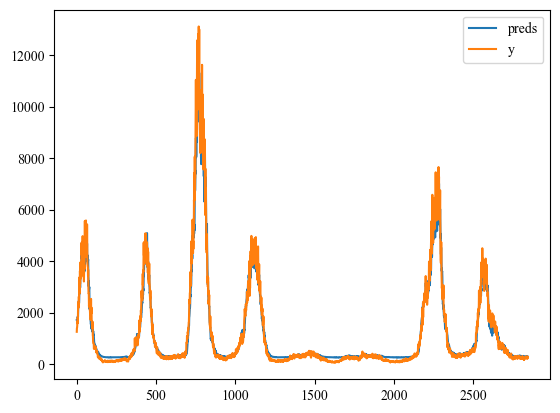

In [16]:
plt.plot(preds_median, label='preds')
plt.plot(y.to("cpu"), label='y')
plt.legend()
plt.show()

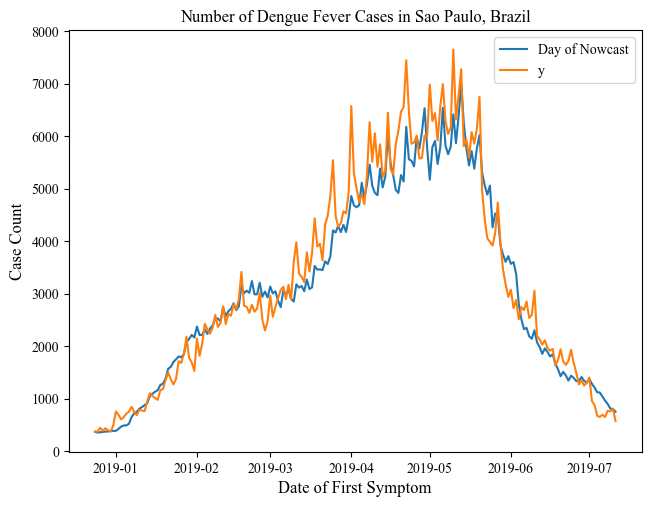

In [35]:
y_plot = y_true[-700:-500]
y_plot.index = pd.to_datetime(y_plot.index)
preds_plot = preds_median[-700:-500]

plt.plot(y_plot.index, preds_plot, label='Day of Nowcast')
plt.plot(y_plot.index, y_plot, label='y')
plt.legend()
plt.tight_layout()
plt.title("Number of Dengue Fever Cases in Sao Paulo, Brazil")
plt.xlabel("Date of First Symptom")
plt.ylabel("Case Count")
# plt.xticks(rotation=45)
plt.show()

In [153]:
def create_fourier_features(t, n, p=365.25):
    x = 2 * np.pi * (pt.arange(n)+1) * t[:, None] / p
    return pt.concatenate((pt.cos(x), pt.sin(x)), axis = 1)

def sampler_kwargs():
    return dict(
        nuts_sampler="nutpie",
        chains=2,
        draws=300,
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"},
        progressbar=False
    )
def mask_matrix(matrix, D):
        masked_matrix = matrix.copy()
        nrow, ncol = masked_matrix.shape

        for i in range(nrow):
            for j in range(ncol):
                if i + j > D - 1:
                     masked_matrix[i, j] = False
        return  masked_matrix

def create_fourier_features(t, n, p=365.25):
    x = 2 * np.pi * (pt.arange(n)+1) * t[:, None] / p
    return pt.concatenate((pt.cos(x), pt.sin(x)), axis = 1)


def get_model_nowcasts(data, n, D, mask, fourier_features):
    with pm.Model() as NN_time_indep_model:
        n_shared = pm.Data("n", n)
        
        # Linear trend parameters
        b0 = pm.Normal("b0", mu=0, sigma=1)   # intercept
        b1 = pm.Normal("b1", mu=0, sigma=0.5)

        
        beta_fourier = pm.Normal("beta_fourier", 0, 0.05, shape=fourier_features.shape[1])
        seasonality = pm.Deterministic(
            "seasonality", pm.math.dot(fourier_features, beta_fourier)
        )
        
        log_lam = b0 + b1 * n_shared + seasonality
        lam = pm.Deterministic("lam", pm.math.exp(log_lam))

        p = pm.Dirichlet("p", a=np.arange(D,0, -1))

        # Create matrix of lam[t,:] * p[t,d]
        mu = lam[:, None] * p[None, :]

        alpha = pm.HalfNormal("alpha", sigma=2)  # overdispersion param
        z = pm.NegativeBinomial("z", mu[mask], alpha, observed=data[mask])

        idata = pm.sample(**sampler_kwargs())

    # with NN_time_indep_model:
    #     #in-sample 
    #     ppc = pm.sample_posterior_predictive(
    #         idata, extend_inferencedata=True,
    #         var_names=['z', 'lam', 'p'], progressbar=False)
        
    return(idata)

matrix, _ = next(iter(train_loader))
matrix = matrix.to("cpu").numpy()[0]
mask = np.ones_like(matrix, dtype=bool)

mask = mask_matrix(mask, model_D)

n = np.arange(0, len(mask)) / len(mask)
fourier_features = create_fourier_features(n, n=20, p=7)


y_label = []
lam_pred = []


for matrix_batch, y_label_batch in plot_loader:
    for t in range(50):
        print(t)
        matrix = matrix_batch[t] * dataset.max_val
        data = matrix.to("cpu").numpy()
        ppc = get_model_nowcasts(data, n, model_D, mask, fourier_features)
        lam_post_samples = az.extract(ppc, group='posterior', num_samples=1000)['lam']
        lam_med = np.percentile(lam_post_samples, 50, axis=1)
        lam_pred.append(lam_med[-1])
        y_label.append(y_label_batch[t].to("cpu").numpy()[0])




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [140]:

print(y_label)
print(lam_pred)

[1253.0, 1394.0, 1421.0, 1497.0, 1666.0, 1582.0, 1804.0, 1735.0, 2007.0, 2407.0]
[2105.841007436161, 1899.6075269680473, 1798.5544938049495, 1678.6181937113784, 1814.1736153829324, 2085.617695888872, 2287.8103150156053, 2100.7759718702537, 2025.9552964969712, 2403.141500738242]


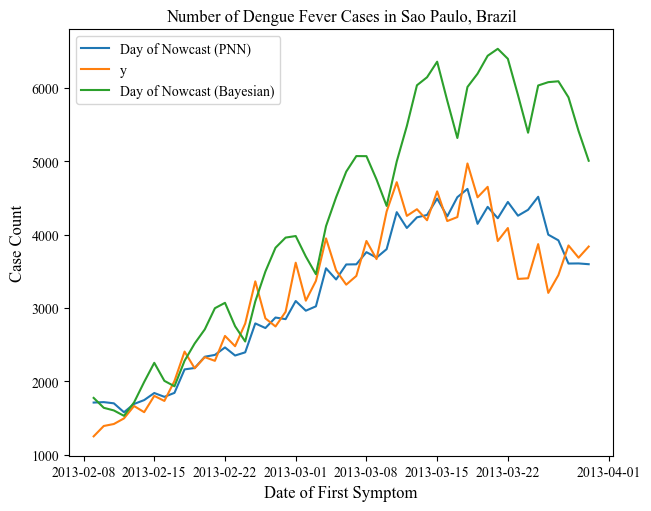

In [154]:
y_plot = y_true[0:50]
y_plot.index = pd.to_datetime(y_plot.index)
preds_plot = preds_median[0:50]

plt.plot(y_plot.index, preds_plot, label='Day of Nowcast (PNN)')
plt.plot(y_plot.index, y_plot, label='y')
plt.plot(y_plot.index, lam_pred, label='Day of Nowcast (Bayesian)')

plt.legend()
plt.tight_layout()
plt.title("Number of Dengue Fever Cases in Sao Paulo, Brazil")
plt.xlabel("Date of First Symptom")
plt.ylabel("Case Count")
# plt.xticks(rotation=45)
plt.show()

In [158]:
next(iter(dataset))

(tensor([[0.0041, 0.0196, 0.0200,  ..., 0.0000, 0.0000, 0.0000],
         [0.0065, 0.0227, 0.0193,  ..., 0.0003, 0.0000, 0.0000],
         [0.0100, 0.0272, 0.0096,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0592, 0.0926, 0.0320,  ..., 0.0000, 0.0000, 0.0000],
         [0.0503, 0.0424, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0368, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
        device='mps:0'),
 tensor([1253.], device='mps:0'))

Train BNN same time as params